In [1]:
# Cell 1: Imports
# Basic OS, date/time, and numerical libraries
import os
from datetime import datetime
import numpy as np

# Libraries for data handling and scientific computing
import xarray as xr
import dask.array as da # For handling large arrays that don't fit in memory

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F # For functions like F.pad
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning for streamlining training
import lightning.pytorch as pl

# Plotting library
import matplotlib.pyplot as plt

# Pandas for data manipulation (e.g., creating submission CSV)
import pandas as pd


In [2]:
# Cell 2: Configuration
# Main configuration dictionary for the experiment

# NOTE: You MUST change the 'path' in config['data'] to the correct location 
# of your 'processed_data_cse151b_v2_corrupted_ssp245.zarr' file.
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"], # Input climate forcing variables
        "output_vars": ["tas", "pr"], # Target variables: surface air temperature and precipitation
        "target_member_id": 0, # Ensemble member to use for target variables
        "train_ssps": ["ssp126", "ssp370", "ssp585"], # SSP scenarios for training
        "test_ssp": "ssp245",  # SSP scenario for testing (held-out)
        "test_months": 120,   # Number of months for the test split (last 10 years)
        "batch_size": 64,     # Batch size for training and evaluation
        "num_workers": 4,     # Number of workers for DataLoader
    },
    "model_unet": { # Configuration specific to U-Net
        "type": "unet",
        "init_features": 64, # Number of features in the first convolutional layer of U-Net
        "bilinear": True,    # Whether to use bilinear upsampling in U-Net's decoder
    },
    "training": {
        "lr": 1e-3, # Learning rate
        # Add other training parameters like weight_decay if needed
    },
    "trainer": {
        "max_epochs": 20,         # Maximum number of training epochs
        "accelerator": "auto",    # Auto-detect accelerator (CPU, GPU, TPU)
        "devices": "auto",        # Auto-detect number of devices
        "precision": 32,          # Training precision (e.g., 16 for mixed-precision)
        "deterministic": True,    # For reproducibility
        "num_sanity_val_steps": 0,# Number of sanity check validation steps before training
        # "logger": True, # Example: WandbLogger(...) or TensorBoardLogger(...)
        # "callbacks": [] # Example: [ModelCheckpoint(...), EarlyStopping(...)]
    },
    "seed": 42, # Seed for reproducibility
}

# Set seed for PyTorch Lightning, PyTorch, NumPy, and Python's random module
pl.seed_everything(config["seed"], workers=True) 

# Suggestion from PyTorch for Tensor Core utilization on compatible GPUs
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7: # Check for Volta architecture or newer
    torch.set_float32_matmul_precision('medium') # or 'high'
    print("Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.")


Seed set to 42


Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.


In [3]:
# Cell 3: Latitude Weights Utility

def get_lat_weights(latitude_values):
    """
    Computes cosine-based area weights for each latitude.
    This accounts for the Earth's curvature, giving more weight to
    grid cells near the equator for global metrics.

    Args:
        latitude_values (np.array): Array of latitude values in degrees.

    Returns:
        np.array: Normalized latitude weights.
    """
    lat_rad = np.deg2rad(latitude_values) # Convert degrees to radians
    weights = np.cos(lat_rad)             # Cosine of latitude
    return weights / np.mean(weights)     # Normalize by the mean weight


In [4]:
# Cell 4: Normalizer Class

class Normalizer:
    """
    Handles Z-score normalization for input and output data.
    (data - mean) / std
    """
    def __init__(self):
        self.mean_in, self.std_in = None, None   # Statistics for input data
        self.mean_out, self.std_out = None, None # Statistics for output data

    def set_input_statistics(self, mean, std):
        """Sets the mean and standard deviation for input data."""
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        """Sets the mean and standard deviation for output data."""
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        """
        Normalizes the data using pre-computed statistics.

        Args:
            data (np.array or dask.array): Data to normalize.
            data_type (str): "input" or "output", to use appropriate statistics.

        Returns:
            Normalized data.
        
        Raises:
            ValueError: If statistics for the specified data_type are not set.
        """
        if data_type == "input":
            if self.mean_in is None or self.std_in is None:
                raise ValueError("Input statistics not set in Normalizer.")
            # Add a small epsilon to std to prevent division by zero if std is very small or zero
            return (data - self.mean_in) / (self.std_in + 1e-8) 
        elif data_type == "output":
            if self.mean_out is None or self.std_out is None:
                raise ValueError("Output statistics not set in Normalizer.")
            return (data - self.mean_out) / (self.std_out + 1e-8)
        else:
            raise ValueError(f"Invalid data_type '{data_type}'. Must be 'input' or 'output'.")

    def inverse_transform_output(self, data):
        """
        Applies inverse normalization to output data (predictions).

        Args:
            data (torch.Tensor or np.array): Normalized output data.

        Returns:
            Data in original physical units.

        Raises:
            ValueError: If output statistics are not set.
        """
        if self.mean_out is None or self.std_out is None:
            raise ValueError("Output statistics not set in Normalizer for inverse transform.")
        return data * (self.std_out + 1e-8) + self.mean_out


In [5]:
# Cell 5: U-Net Model Architecture
# (DoubleConv, Down, Up, OutConv, UNet classes)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels_x1, in_channels_x2, out_channels, bilinear=True):
        super().__init__()
        # in_channels_x1: channels of the feature map from the upsampling path (lower layer in decoder)
        # in_channels_x2: channels of the feature map from the skip connection (encoder)
        # out_channels: channels produced by this Up block

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # After upsampling x1, its channel count (in_channels_x1) remains the same.
            # It's then concatenated with x2 (in_channels_x2).
            # So, the input to DoubleConv is (in_channels_x1 + in_channels_x2).
            self.conv = DoubleConv(in_channels_x1 + in_channels_x2, out_channels)
        else:
            # ConvTranspose2d halves the channels of x1 (in_channels_x1 -> in_channels_x1 // 2)
            self.up = nn.ConvTranspose2d(in_channels_x1, in_channels_x1 // 2, kernel_size=2, stride=2)
            # Input to DoubleConv is (in_channels_x1 // 2 + in_channels_x2)
            self.conv = DoubleConv(in_channels_x1 // 2 + in_channels_x2, out_channels)


    def forward(self, x1, x2):
        # x1: feature map from upsampling path (e.g., from x_bottleneck or previous Up layer)
        # x2: feature map from skip connection (encoder path, e.g., x4_skip)
        x1 = self.up(x1)
        
        # Pad x1 to match x2's spatial dimensions if they differ
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1) # Concatenate along channel dimension
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, bilinear=True, init_features=64):
        super(UNet, self).__init__()
        self.n_input_channels = n_input_channels
        self.n_output_channels = n_output_channels
        self.bilinear = bilinear
        self.init_features = init_features 
        
        f = init_features # Short alias

        # Encoder
        self.inc = DoubleConv(n_input_channels, f)
        self.down1 = Down(f, f * 2)
        self.down2 = Down(f * 2, f * 4)
        self.down3 = Down(f * 4, f * 8)
        self.down4 = Down(f * 8, f * 16) # Bottleneck input features

        # Decoder
        # Arguments for Up: (channels_from_lower_upsampled_layer, channels_from_skip_connection, output_channels_for_this_Up_block)
        self.up1 = Up(f * 16, f * 8,  f * 8, bilinear)
        self.up2 = Up(f * 8,  f * 4,  f * 4, bilinear)
        self.up3 = Up(f * 4,  f * 2,  f * 2, bilinear)
        self.up4 = Up(f * 2,  f,      f,     bilinear)
        
        self.outc = OutConv(f, n_output_channels)

    def forward(self, x):
        x1_skip = self.inc(x)           # -> f
        x2_skip = self.down1(x1_skip)   # -> f * 2
        x3_skip = self.down2(x2_skip)   # -> f * 4
        x4_skip = self.down3(x3_skip)   # -> f * 8
        x_bottleneck = self.down4(x4_skip) # -> f * 16

        # Decoder
        x = self.up1(x_bottleneck, x4_skip) # x_bottleneck (f*16), x4_skip (f*8). Up outputs f*8
        x = self.up2(x, x3_skip)            # x (f*8), x3_skip (f*4). Up outputs f*4
        x = self.up3(x, x2_skip)            # x (f*4), x2_skip (f*2). Up outputs f*2
        x = self.up4(x, x1_skip)            # x (f*2), x1_skip (f). Up outputs f
        
        logits = self.outc(x)
        return logits


In [6]:
# Cell 6: ClimateDataset and ClimateDataModule

class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        """
        PyTorch Dataset for climate data.

        Args:
            inputs_dask (dask.array): Dask array of input features.
            outputs_dask (dask.array): Dask array of output targets.
            output_is_normalized (bool): Flag indicating if outputs_dask is already normalized.
                                         Used for the test set where targets are not pre-normalized.
        """
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any():
            raise ValueError("NaNs found in input dataset after converting to tensor.")
        if torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in output dataset after converting to tensor.")
        
        print(f"Dataset created. Input shape: {self.inputs.shape}, Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42, 
    ):
        super().__init__()
        self.save_hyperparameters() 
        self.normalizer = Normalizer()

    def prepare_data(self):
        if not os.path.exists(self.hparams.path):
            raise FileNotFoundError(f"Data path not found: {self.hparams.path}. Please check config['data']['path'].")

    def setup(self, stage=None):
        ds = xr.open_zarr(self.hparams.path, consolidated=False, chunks={"time": 24})
        
        # --- FIX for spatial_template ---
        # The 'rsdt' variable might not have 'member_id'. Handle this conditionally.
        rsdt_var_for_template = ds["rsdt"]
        if "member_id" in rsdt_var_for_template.dims:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, member_id=0, drop=True)
        else:
            # If 'member_id' is not present, select without it.
            # This assumes 'rsdt' is consistent across members or doesn't have that dimension.
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, drop=True)
        # --- END FIX ---

        def load_ssp(ssp_name):
            input_dask_list, output_dask_list = [], []
            
            for var_name in self.hparams.input_vars:
                da_var = ds[var_name].sel(ssp=ssp_name)
                if "latitude" in da_var.dims: 
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                # For input variables, if member_id exists, select the target_member_id.
                # If it doesn't exist (e.g. for some forcing data), this sel will be a no-op if strict=False,
                # or we can check existence. Xarray's sel is usually robust if the dim doesn't exist.
                # However, to be safe, let's check.
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.hparams.target_member_id)
                
                if set(da_var.dims) == {"time"}: 
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            
            for var_name in self.hparams.output_vars:
                # Output variables are always selected by target_member_id
                da_out = ds[var_name].sel(ssp=ssp_name, member_id=self.hparams.target_member_id)
                if "latitude" in da_out.dims: 
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_list, train_output_list = [], []
        val_input_ssp370, val_output_ssp370 = None, None

        for ssp in self.hparams.train_ssps:
            x_ssp, y_ssp = load_ssp(ssp)
            if ssp == "ssp370": 
                val_input_ssp370 = x_ssp[-self.hparams.test_months:]
                val_output_ssp370 = y_ssp[-self.hparams.test_months:]
                train_input_list.append(x_ssp[:-self.hparams.test_months])
                train_output_list.append(y_ssp[:-self.hparams.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)
        
        train_input_all_ssp = da.concatenate(train_input_list, axis=0)
        train_output_all_ssp = da.concatenate(train_output_list, axis=0)

        input_mean = da.nanmean(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)

        output_mean = da.nanmean(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm = self.normalizer.normalize(train_input_all_ssp, "input")
        train_output_norm = self.normalizer.normalize(train_output_all_ssp, "output")
        
        val_input_norm = self.normalizer.normalize(val_input_ssp370, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370, "output")

        test_input_ssp, test_output_ssp = load_ssp(self.hparams.test_ssp)
        test_input_ssp = test_input_ssp[-self.hparams.test_months:] 
        test_output_ssp = test_output_ssp[-self.hparams.test_months:]
        test_input_norm = self.normalizer.normalize(test_input_ssp, "input")

        if stage == "fit" or stage is None:
            self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
            self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        if stage == "test" or stage is None:
            self.test_dataset = ClimateDataset(test_input_norm, test_output_ssp, output_is_normalized=False)
        
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        ds.close()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


In [7]:
# Cell 7: ClimateEmulationModule (PyTorch Lightning)

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model 
        self.save_hyperparameters(ignore=['model']) 
        
        self.criterion = nn.MSELoss() 
        self.normalizer = None 
        
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def _get_normalizer_from_datamodule(self):
        """Helper to safely get normalizer from datamodule."""
        if hasattr(self.trainer, 'datamodule') and self.trainer.datamodule is not None and hasattr(self.trainer.datamodule, 'normalizer'):
            return self.trainer.datamodule.normalizer
        else:
            # Fallback if trainer.datamodule is not set up (e.g. direct call to test without fit)
            # This requires 'config' to be globally accessible or passed differently.
            print("Warning: Normalizer not found via self.trainer.datamodule. Attempting fallback initialization.")
            temp_dm = ClimateDataModule(**config["data"]) 
            temp_dm.prepare_data()
            temp_dm.setup(stage="test") # Or appropriate stage to ensure normalizer stats are computed
            return temp_dm.normalizer


    def on_fit_start(self):
        """Called at the beginning of training."""
        self.normalizer = self._get_normalizer_from_datamodule()

    def on_test_start(self):
        """Called at the beginning of testing."""
        if self.normalizer is None: # Ensure normalizer is available
            self.normalizer = self._get_normalizer_from_datamodule()


    def training_step(self, batch, batch_idx):
        x, y_norm = batch 
        y_hat_norm = self(x)   
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_norm = batch
        y_hat_norm = self(x)
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        y_denorm = self.normalizer.inverse_transform_output(y_norm.detach().cpu().numpy())
        
        self.val_preds.append(y_hat_denorm)
        self.val_targets.append(y_denorm)
        return loss 

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: # Skip during sanity check
            if not self.val_preds or not self.val_targets: 
                return

            preds_epoch = np.concatenate(self.val_preds, axis=0)
            trues_epoch = np.concatenate(self.val_targets, axis=0)
            
            if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
            
            self._evaluate(preds_epoch, trues_epoch, phase="val")
            
            np.save("val_preds.npy", preds_epoch)
            np.save("val_trues.npy", trues_epoch)
            
            self.val_preds.clear() 
            self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y_true_denorm = batch 
        y_hat_norm = self(x)    

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
        
        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        
        self.test_preds.append(y_hat_denorm)
        self.test_targets.append(y_true_denorm.detach().cpu().numpy()) 

    def on_test_epoch_end(self):
        if not self.test_preds or not self.test_targets: 
            return

        preds_epoch = np.concatenate(self.test_preds, axis=0)
        trues_epoch = np.concatenate(self.test_targets, axis=0)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        self._evaluate(preds_epoch, trues_epoch, phase="test")
        self._save_submission(preds_epoch) 
        
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def _evaluate(self, preds_np, trues_np, phase="val"):
        """Calculates and logs evaluation metrics."""
        # This check is important for when _evaluate might be called outside trainer.fit/test context
        # or if datamodule is not correctly propagated.
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_lat_weights'):
            print("Warning: self.trainer.datamodule not fully available in _evaluate. Using fallback for coords/weights.")
            dm_eval = ClimateDataModule(**config["data"]) # Re-init for coords, assumes global config
            dm_eval.prepare_data()
            dm_eval.setup(stage=phase) # Setup for the correct stage
            area_weights = dm_eval.get_lat_weights()
            lat, lon = dm_eval.get_coords()
            output_vars = dm_eval.hparams.output_vars
        else:
            area_weights = self.trainer.datamodule.get_lat_weights()
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars


        time_coords = np.arange(preds_np.shape[0])
        metrics_summary = {}

        for i, var_name in enumerate(output_vars):
            p_var = preds_np[:, i] 
            t_var = trues_np[:, i] 
            
            p_xr = xr.DataArray(p_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})
            t_xr = xr.DataArray(t_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean()).item()
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean()).item()
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean().item()

            print(f"[{phase.upper()}] {var_name}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            
            metrics_summary[f"{phase}/{var_name}/rmse"] = rmse
            metrics_summary[f"{phase}/{var_name}/time_mean_rmse"] = mean_rmse
            metrics_summary[f"{phase}/{var_name}/time_std_mae"] = std_mae
        
        self.log_dict(metrics_summary, logger=True)

    def _save_submission(self, predictions_np):
        """Saves model predictions to a CSV file in Kaggle submission format."""
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_coords'):
            print("Warning: self.trainer.datamodule not fully available in _save_submission. Using fallback.")
            dm_submission = ClimateDataModule(**config["data"])
            dm_submission.prepare_data()
            dm_submission.setup(stage="test") # Ensure coords are loaded
            lat, lon = dm_submission.get_coords()
            output_vars = dm_submission.hparams.output_vars
        else:
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars
            
        time_coords_submission = np.arange(predictions_np.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time_coords_submission):
            for var_idx, var_name in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var_name}_{y_val:.2f}_{x_val:.2f}"
                        pred_value = predictions_np[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred_value})

        submission_df = pd.DataFrame(rows)
        submission_dir = "submissions"
        os.makedirs(submission_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filepath = os.path.join(submission_dir, f"kaggle_submission_unet_{timestamp}.csv")
        submission_df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")


In [8]:
# Cell 8: Training and Evaluation Script

# --- Instantiate DataModule ---
datamodule = ClimateDataModule(**config["data"])
# datamodule.prepare_data() # Called by Trainer when .fit() or .test() is called
# datamodule.setup()      # Called by Trainer when .fit() or .test() is called

# --- Instantiate U-Net Model ---
n_inputs = len(config["data"]["input_vars"])
n_outputs = len(config["data"]["output_vars"])

unet_config_params = config.get("model_unet", {}) 
init_features = unet_config_params.get("init_features", 64)
bilinear_upsampling = unet_config_params.get("bilinear", True)

unet_model = UNet(n_input_channels=n_inputs, 
                  n_output_channels=n_outputs, 
                  init_features=init_features,
                  bilinear=bilinear_upsampling)

# --- Instantiate Lightning Module ---
learning_rate = config["training"]["lr"]
lightning_module = ClimateEmulationModule(unet_model, learning_rate=learning_rate)

# --- Setup Trainer ---
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor="val/loss", 
    mode="min",         
    filename="unet-best-{epoch:02d}-{val/loss:.2f}", 
    save_top_k=1,       
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor="val/loss",
    patience=5, 
    verbose=True,
    mode="min"
)

trainer_params = {**config["trainer"]} 
trainer_params["callbacks"] = [checkpoint_callback, early_stop_callback]
# Optional: Add logger
# from lightning.pytorch.loggers import TensorBoardLogger
# logger = TensorBoardLogger("tb_logs", name="unet_climate_emulation")
# trainer_params["logger"] = logger

trainer = pl.Trainer(**trainer_params)

# --- Train the Model ---
print("Starting U-Net model training...")
trainer.fit(lightning_module, datamodule=datamodule)
print("Training finished.")

# --- Test the Model ---
print("Starting U-Net model testing using the best checkpoint...")
# trainer.test will use the checkpoint_callback's best_model_path by default if available
# or you can specify ckpt_path="best"
test_results = trainer.test(lightning_module, datamodule=datamodule, ckpt_path="best") 
print("Testing finished.")
print("Test Results:", test_results)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting U-Net model training...
Creating dataset with 2943 samples...
Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])



  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.4 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.544   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.411
Epoch 0, global step 46: 'val/loss' reached 0.41131 (best 0.41131), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=00-val/loss=0.41.ckpt' as top 1


[VAL] tas: RMSE=4.9242, Time-Mean RMSE=3.3147, Time-Stddev MAE=1.3951
[VAL] pr: RMSE=3.0942, Time-Mean RMSE=1.4302, Time-Stddev MAE=1.7080


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.072 >= min_delta = 0.0. New best score: 0.339
Epoch 1, global step 92: 'val/loss' reached 0.33930 (best 0.33930), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=01-val/loss=0.34.ckpt' as top 1


[VAL] tas: RMSE=4.1480, Time-Mean RMSE=2.4466, Time-Stddev MAE=1.2698
[VAL] pr: RMSE=2.8289, Time-Mean RMSE=1.0629, Time-Stddev MAE=1.4826


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.090 >= min_delta = 0.0. New best score: 0.249
Epoch 2, global step 138: 'val/loss' reached 0.24908 (best 0.24908), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=02-val/loss=0.25.ckpt' as top 1


[VAL] tas: RMSE=3.2438, Time-Mean RMSE=2.2213, Time-Stddev MAE=0.8985
[VAL] pr: RMSE=2.4371, Time-Mean RMSE=0.8571, Time-Stddev MAE=1.1212


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.029 >= min_delta = 0.0. New best score: 0.220
Epoch 3, global step 184: 'val/loss' reached 0.21987 (best 0.21987), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=03-val/loss=0.22.ckpt' as top 1


[VAL] tas: RMSE=2.8492, Time-Mean RMSE=2.0517, Time-Stddev MAE=0.7391
[VAL] pr: RMSE=2.2947, Time-Mean RMSE=0.7773, Time-Stddev MAE=0.9232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.022 >= min_delta = 0.0. New best score: 0.198
Epoch 4, global step 230: 'val/loss' reached 0.19783 (best 0.19783), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=04-val/loss=0.20.ckpt' as top 1


[VAL] tas: RMSE=2.5626, Time-Mean RMSE=1.8202, Time-Stddev MAE=0.6748
[VAL] pr: RMSE=2.1822, Time-Mean RMSE=0.6090, Time-Stddev MAE=0.9695


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 276: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.4039, Time-Mean RMSE=1.7028, Time-Stddev MAE=0.6017
[VAL] pr: RMSE=2.2557, Time-Mean RMSE=0.7858, Time-Stddev MAE=0.9151


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.192
Epoch 6, global step 322: 'val/loss' reached 0.19163 (best 0.19163), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=06-val/loss=0.19.ckpt' as top 1


[VAL] tas: RMSE=2.3947, Time-Mean RMSE=1.7407, Time-Stddev MAE=0.5837
[VAL] pr: RMSE=2.1556, Time-Mean RMSE=0.6035, Time-Stddev MAE=0.8847


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 368: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.3392, Time-Mean RMSE=1.6698, Time-Stddev MAE=0.5722
[VAL] pr: RMSE=2.1733, Time-Mean RMSE=0.6303, Time-Stddev MAE=0.8069


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.186
Epoch 8, global step 414: 'val/loss' reached 0.18618 (best 0.18618), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=08-val/loss=0.19.ckpt' as top 1


[VAL] tas: RMSE=2.2066, Time-Mean RMSE=1.5210, Time-Stddev MAE=0.5580
[VAL] pr: RMSE=2.1264, Time-Mean RMSE=0.5509, Time-Stddev MAE=0.8341


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.181
Epoch 9, global step 460: 'val/loss' reached 0.18084 (best 0.18084), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=09-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.2742, Time-Mean RMSE=1.6626, Time-Stddev MAE=0.5297
[VAL] pr: RMSE=2.0963, Time-Mean RMSE=0.4971, Time-Stddev MAE=0.8151


`Trainer.fit` stopped: `max_epochs=10` reached.


Training finished.
Starting U-Net model testing using the best checkpoint...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=09-val/loss=0.18.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_2/checkpoints/unet-best-epoch=09-val/loss=0.18.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.5078, Time-Mean RMSE=290.4697, Time-Stddev MAE=3.4301
[TEST] pr: RMSE=4.2919, Time-Mean RMSE=3.8092, Time-Stddev MAE=1.3929
✅ Submission saved to: submissions/kaggle_submission_unet_20250517_033424.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.291896343231201     │
│  test/pr/time_mean_rmse   │    3.8091659545898438     │
│   test/pr/time_std_mae    │    1.3928557634353638     │
│       test/tas/rmse       │     290.5077819824219     │
│  test/tas/time_mean_rmse  │      290.4697265625       │
│   test/tas/time_std_mae   │     3.430088996887207     │
└───────────────────────────┴───────────────────────────┘

Testing finished.
Test Results: [{'test/tas/rmse': 290.5077819824219, 'test/tas/time_mean_rmse': 290.4697265625, 'test/tas/time_std_mae': 3.430088996887207, 'test/pr/rmse': 4.291896343231201, 'test/pr/time_mean_rmse': 3.8091659545898438, 'test/pr/time_std_mae': 1.3928557634353638}]


In [9]:
# Cell 9: Plotting Utilities (Optional)
# Ensure matplotlib, numpy, and xarray are imported (usually in Cell 1)

def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric_val=None, metric_name="Metric"):
    """
    Plots a comparison between ground truth, prediction, and their difference.
    Includes calculation and display of a spatial mean metric (e.g., RMSE).
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    fig.suptitle(title, fontsize=16) 

    common_min = min(true_xr.min().item(), pred_xr.min().item())
    common_max = max(true_xr.max().item(), pred_xr.max().item())

    true_xr.plot(ax=axs[0], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': true_xr.name or 'Value'})
    axs[0].set_title(f"Ground Truth")

    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': pred_xr.name or 'Value'})
    axs[1].set_title(f"Prediction")

    diff = pred_xr - true_xr
    abs_max_diff = np.max(np.abs(diff.data)) if diff.size > 0 else 0.1 
    
    diff_plot_params = {'cmap': diff_cmap, 'add_colorbar': True, 'cbar_kwargs': {'label': 'Difference'}}
    if abs_max_diff > 0: 
        diff_plot_params['vmin'] = -abs_max_diff
        diff_plot_params['vmax'] = abs_max_diff
        
    diff.plot(ax=axs[2], **diff_plot_params)
    
    title_suffix = ""
    if metric_val is not None:
        title_suffix = f" ({metric_name}: {metric_val:.4f})"
    axs[2].set_title(f"Difference (Pred - Truth){title_suffix}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



--- Visualizing Validation Predictions for U-Net ---


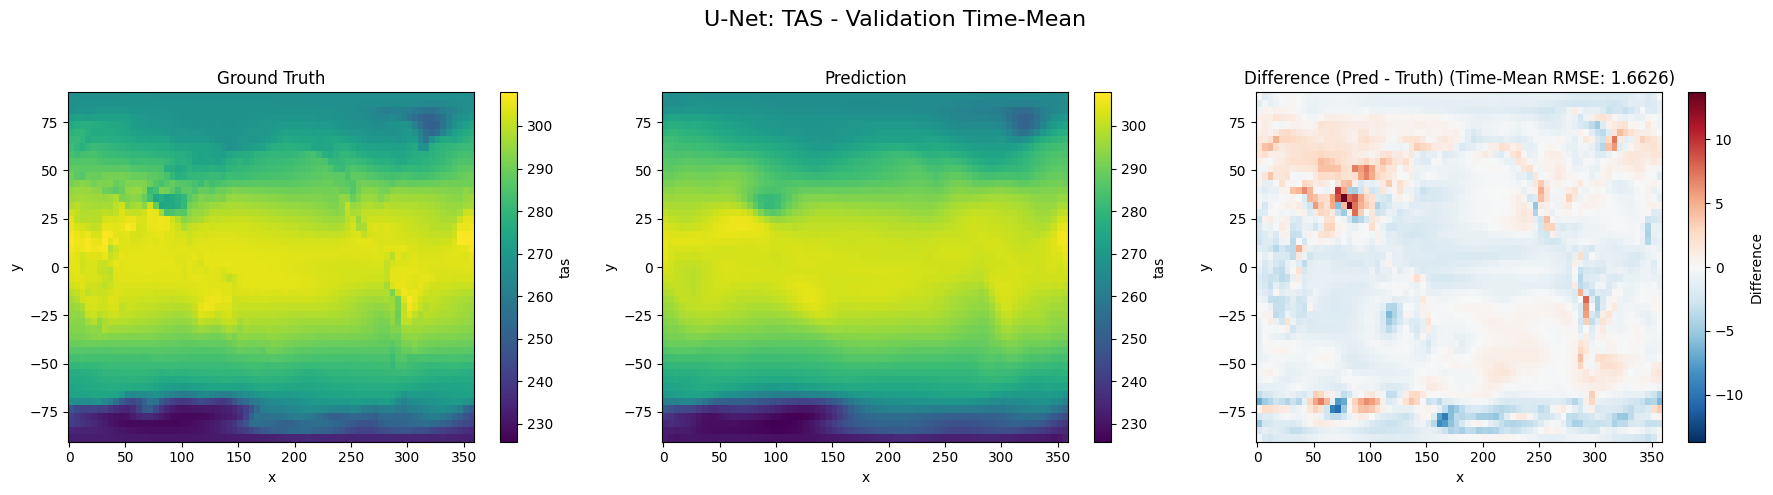

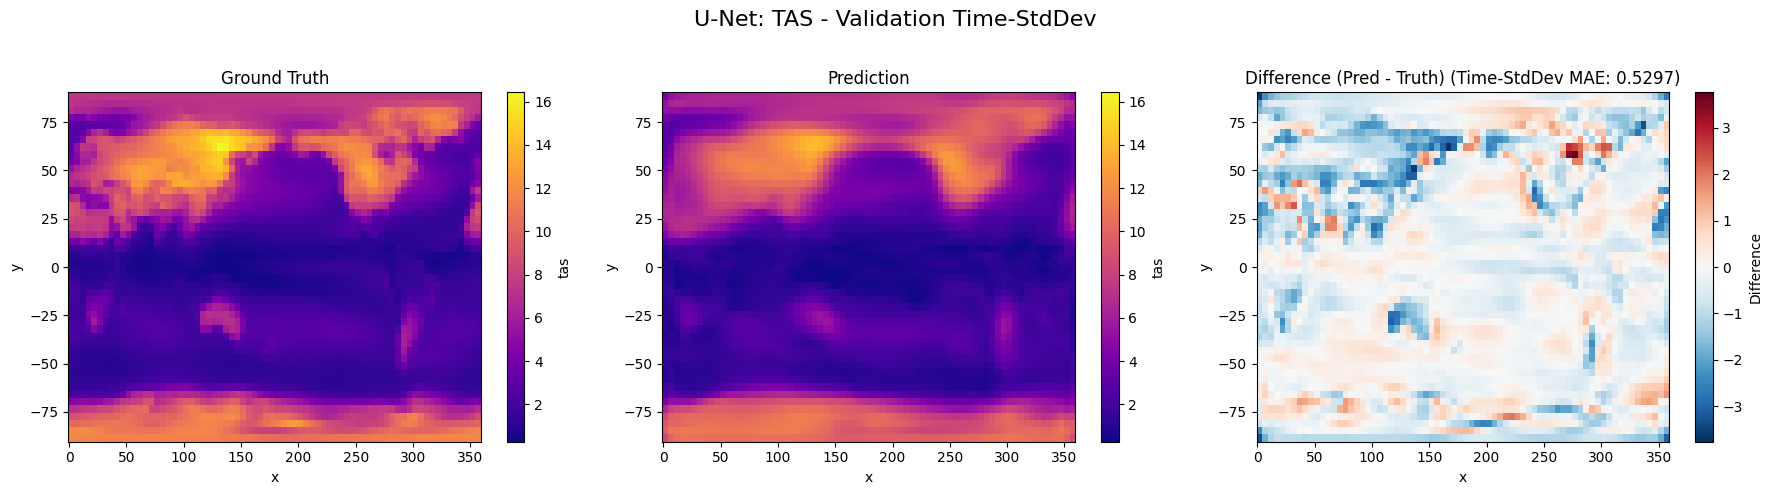

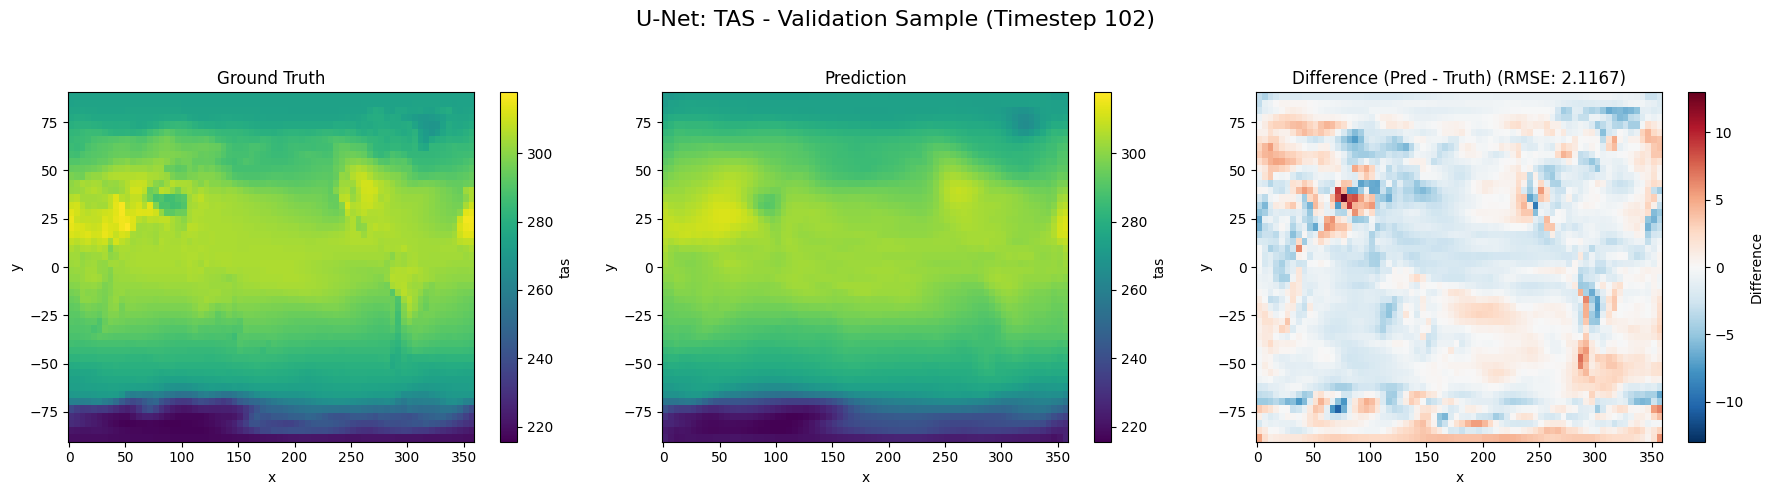

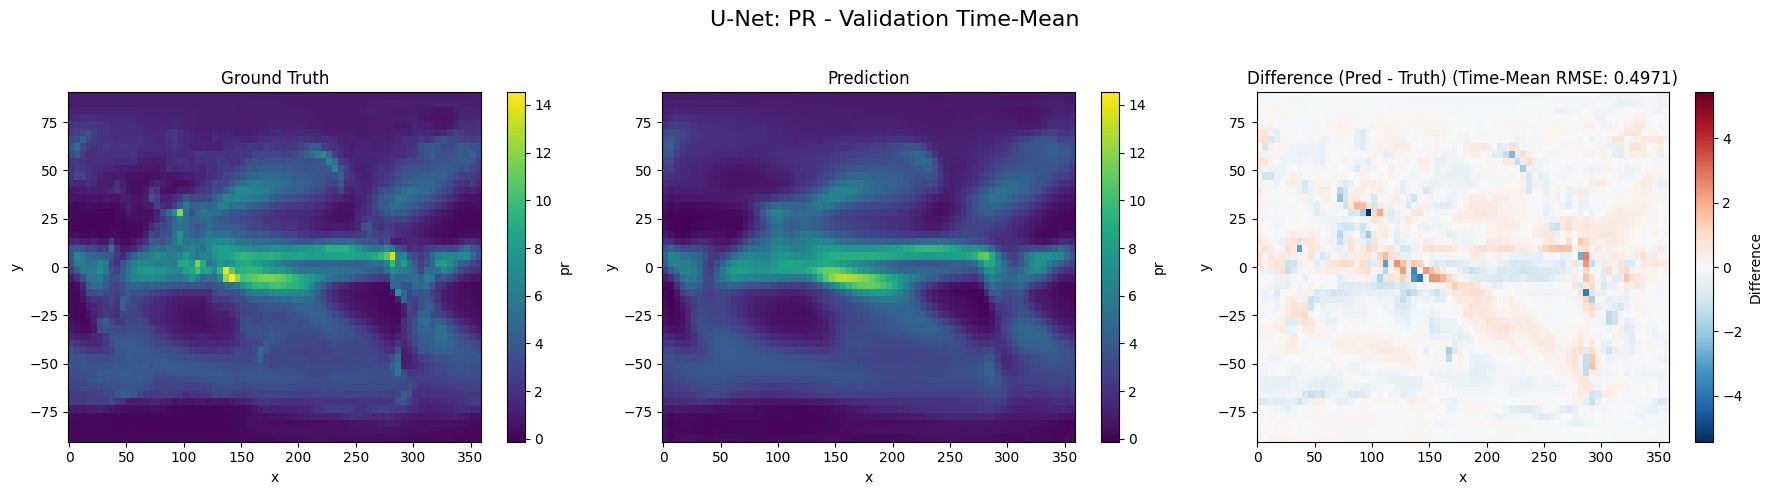

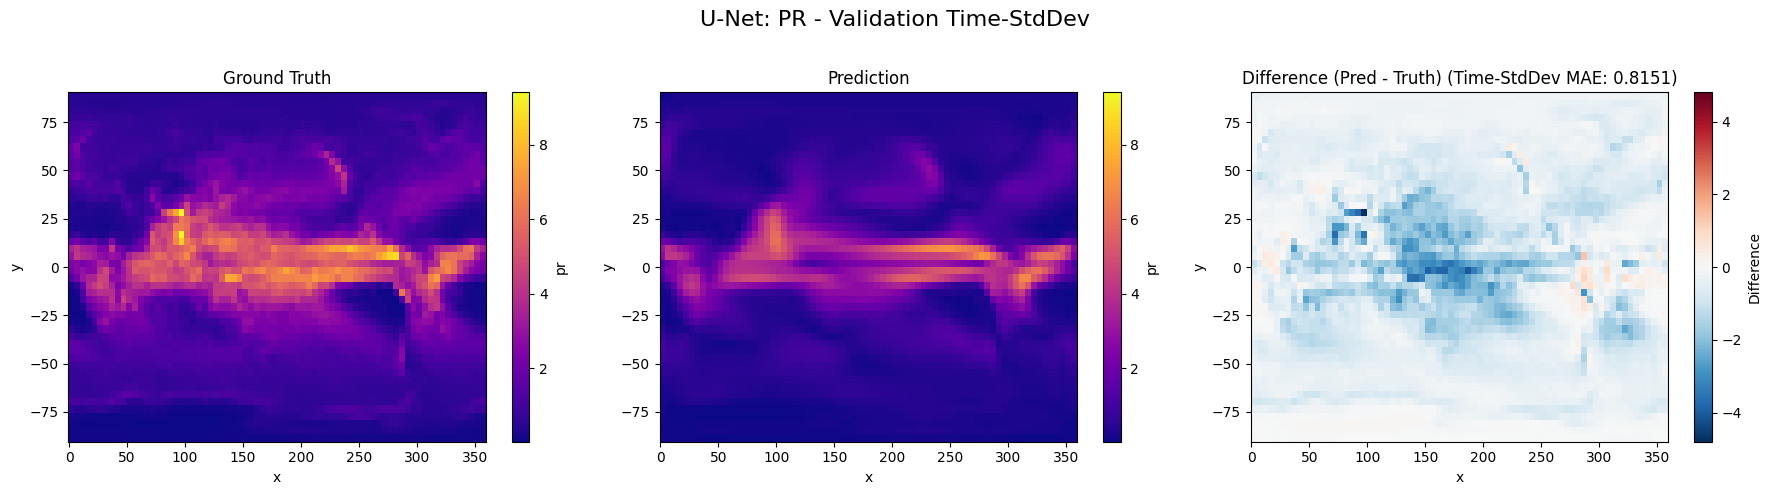

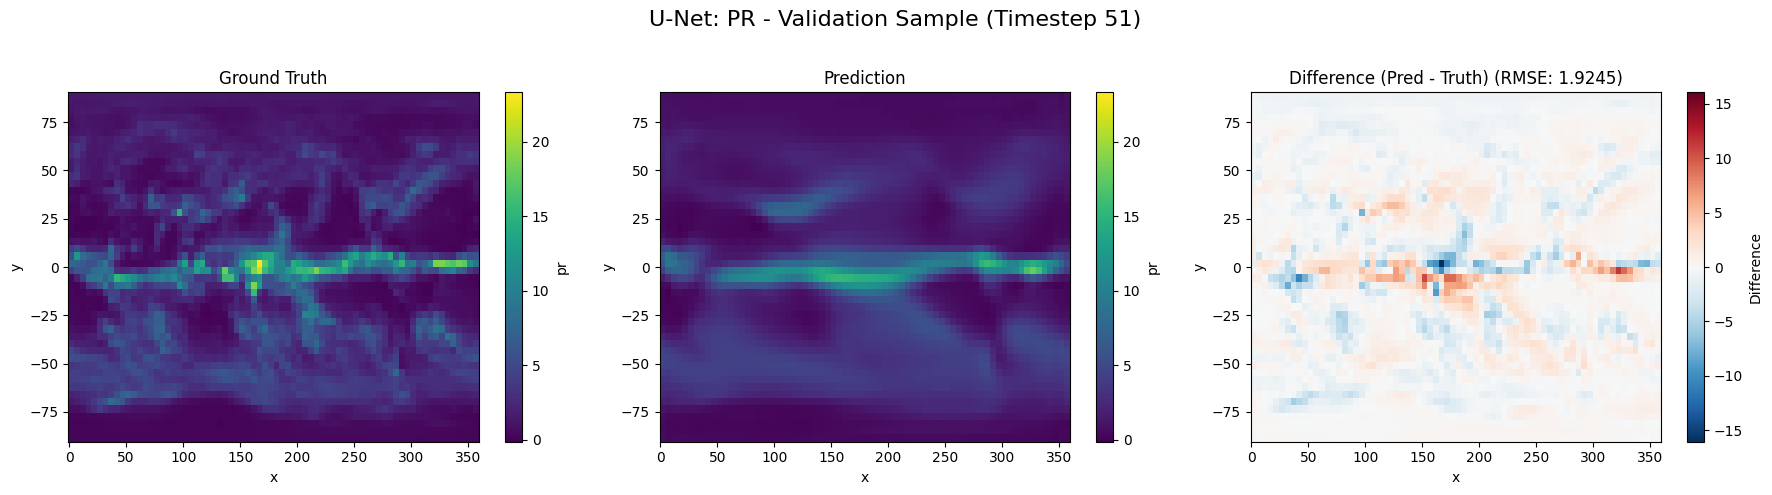

In [10]:
# Cell 10: Visualization Script (Optional)

try:
    val_preds_loaded = np.load("val_preds.npy")
    val_trues_loaded = np.load("val_trues.npy")

    if not hasattr(datamodule, 'lat') or datamodule.lat is None:
        print("Datamodule not fully set up for visualization. Setting it up...")
        # datamodule.prepare_data() # Should have been called by trainer
        datamodule.setup(stage="fit") # Ensure lat, lon, etc. are available

    lat, lon = datamodule.get_coords()
    output_vars = config["data"]["output_vars"] 
    area_weights_vis = datamodule.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded.shape[0])

    print(f"\n--- Visualizing Validation Predictions for U-Net ---")
    for i, var_name in enumerate(output_vars):
        pred_xr = xr.DataArray(val_preds_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr = xr.DataArray(val_trues_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean = pred_xr.mean("time")
        true_mean = true_xr.mean("time")
        mean_rmse_var = np.sqrt(((pred_mean - true_mean) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean, pred_mean, 
                        f"U-Net: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var, metric_name="Time-Mean RMSE")

        pred_std = pred_xr.std("time")
        true_std = true_xr.std("time")
        std_mae_var = np.abs(pred_std - true_std).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std, pred_std, 
                        f"U-Net: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random = np.random.randint(0, len(time_val_coords))
            pred_sample = pred_xr.isel(time=t_idx_random)
            true_sample = true_xr.isel(time=t_idx_random)
            sample_rmse_var = np.sqrt(((pred_sample - true_sample) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample, pred_sample, 
                            f"U-Net: {var_name.upper()} - Validation Sample (Timestep {t_idx_random})",
                            metric_val=sample_rmse_var, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found. "
          "Ensure that the training and validation loop (trainer.fit) has been run successfully, "
          "and the on_validation_epoch_end method in ClimateEmulationModule saved these files.")
except AttributeError as e:
    print(f"AttributeError during visualization: {e}. Ensure datamodule is correctly initialized and set up.")
    print("This might happen if 'datamodule' from the training cell is not in scope or wasn't fully set up.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

